<a href="https://colab.research.google.com/github/ChethanaW/LURA-Lassonde-Undergradutae-Research-Project/blob/main/LURA_Concept.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
import numpy as np
from numpy import random
from scipy import signal
import math
import matplotlib.pyplot as plt

# Global Functions

In [ ]:
# General functions
def sigma_sum(start, end, expression):
    return sum(expression(i) for i in range(start, end))

# **1D signal space**

### Changes to lab2 and lab3 for on-off keying considering optimal standards as possible

In [ ]:

def trial_1(s0, s1,hk,nb,ts,n0,nt):
  error_count =0
  zero_count =0
  one_count = 0
  # size_nb = len(nb)
  # tb = size_nb*ts
  binary_vector = []
  modulated_vector = []
  noisy_signal = []
  out_array = []
  noise_array = []
  results_array = []

  output = {}

  #optimal h[k] is the reverse of h[k] (not sure exactly why? need to check)
  hk = np.flip(hk)

  #noise-free filter outputs for the 2 sequences
  #note ns0 = 0 because s0[k] is a [0,0,0,..] vector (depicting no signal)
  ns0 =  np.dot(s0,hk)
  ns1 =  np.dot(s1,hk)

  for i in range(0, nt):
    # Generate random bit
    x = random.choice([0,1])
    binary_vector.append(x)

    # modulation
    if x == 0:
      mod_signal = s0# no signal
    else:
      mod_signal = s1#signal
    
    modulated_vector = np.append(modulated_vector,mod_signal)

    # Generate guassian white noise
    a = sigma_sum(0, nb, lambda i: (hk[i])**2 )
    v = ((n0*a)/(2*ts))# variance
    v2= n0/(2*ts) # pg 22 "Since n[k] is an AWGN random process with mean zero and variance N0/2Ts (from (2.10))""
    # print(v2)
    noise = np.random.normal(0,math.sqrt(v2),nb) # np.random.normal(mean,std,size) 
    
    #https://www.mathsisfun.com/data/standard-deviation.html
    # noise = np.random.normal(0,math.sqrt(v/(nb-1)),nb) 

    # addition of white noise
    if x == 0:
      y = np.add(s0,noise)# no signal
    else:
      y = np.add(s1,noise) # signal present

    noisy_signal = np.append(noisy_signal,y)

    #detecting the bit
    out = np.dot(y,hk)
    noise_array.append(np.dot(noise,hk))
    out_array.append(out)

    #optimal threshold (z)
    # a = sigma_sum(0, nb-1, lambda i: (hk[i])**2 )
    # v = (n0*a)/(2*ts) # variance
    # z = (v/(ns0-ns1) * log(prob_of_one/prob_of_zero)) + (ns0+ns1)/2 (we dont know what the prob of each bit generated)
    #or but below is assuming 0 and 1 generated are equiprobable, which will not be true always according to this code
    z = (ns1+ns0)/2  # threshold
    
    if out <= z:
      result = 0
      zero_count +=1
    else:
      result = 1
      one_count +=1

    results_array.append(result)

    #count detection errors
    if result != x:
      error_count += 1

  prob_error = (error_count/nt)
  prob_one = 0.5
  prob_zero = 0.5

  # #variance again
  # mean = np.mean(results_array)
  # new_v = (sigma_sum(0, len(results_array), lambda i: (results_array[i] - mean)**2 ))/(len(results_array) -1)

  # noise only through filter
  # mean = np.mean(results_array)
  # v_from_noise = (sigma_sum(0, len(noise_array), lambda i: (noise_array[i])**2 ))/(len(results_array) -1)
  v_from_noise = 0
  for i in range(0, len(noise_array)):
    v_from_noise += np.power(noise_array[i], 2)

  v_from_noise = v_from_noise/len(noise_array)
  
  # theoratical probability error
  # theor_prob_error = ( 0.5*math.erfc( (ns0-z)/math.sqrt(2*v) )*prob_zero ) + ( 0.5*math.erfc( (z-ns1)/math.sqrt(2*v) )*prob_one )
  theor_prob_error = ( (1/2)*math.erfc( (z-ns0)/math.sqrt(2*v) )*prob_zero ) + ( (1/2)*math.erfc( (ns1-z)/math.sqrt(2*v) )*prob_one )

  output["noise-free filter for s0[k]"] = ns0
  output["noise-free filter for s1[k]"] = ns1
  output["before, after variance, and variance from noise"] = [v,  v_from_noise]
  output["Threshold"] = z
  output["Generated bits"] = binary_vector
  output["Modulated vector"] = modulated_vector
  output["Noisy signal(y)"] =  noisy_signal
  output["Noisy signal(y) dot product filter for detection purposes"] =  out_array
  output["Noise array"] = noise_array

  output["Resulting bits afer detection"] = results_array
  output["Simulated probablity error"] = prob_error
  output["Theoratical probablity error"] = theor_prob_error

  output["probablity of one"] = prob_one
  output["probablity of zero"] = prob_zero

  return output


In [ ]:
s0=[0,0,0] # sequence 1
s1=[1,1,1] # sequence 2
hk=[1,1,1] # filter
nb=3 # size of the sequnce/filter
ts=10e-4 # samplying time
n0=0.1  # a constant proportional to temperature of device (according to the book)
nt=100 # number of trial

r = trial_1(s0, s1,hk,nb,ts,n0,nt)
r["Simulated probablity error"], r["Theoratical probablity error"] , r["probablity of one"], r["probablity of zero"]
r["before, after variance, and variance from noise"]
# , r["Generated bits"],r["Resulting bits afer detection"]

[150.00000000000003, 170.93958401680763]

#### Prob/Theo vs N0

In [ ]:
def get_theoandprob_data_trial1(s0, s1,hk,nb,ts,n0,nt):
  prob_error = []
  theo_error = []
  noise_arr = []

  output = {}

  for no_e in n0:
    result = trial_1(s0, s1,hk,nb,ts,no_e,nt)

    prob_error.append(result["Simulated probablity error"])
    theo_error.append(result["Theoratical probablity error"])
    noise_arr.append(result["Noise array"])

  output["THEO"] = theo_error
  output["SIMUL"] = prob_error
  output["Noise array"] = result["Noise array"]
  output["noise_arr"] = noise_arr

  return output

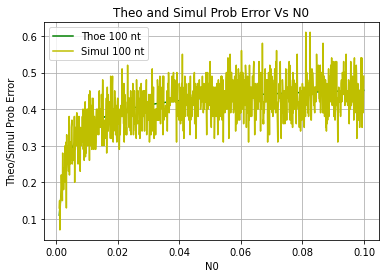

In [ ]:
# nb = 100
# s0=[random.randint(1,10) for i in range(nb)]
# s1=[random.randint(1,10) for i in range(nb)]
# hk=[random.randint(1,10) for i in range(nb)]

s0=[0,0,0] # sequence 1
s1=[1,1,1] # sequence 2
hk=[1,1,1] # filter
nb=3 # size of the sequnce/filter

ts=10e-4
n0=np.arange(0.001 ,0.1, 0.0001)

# result1 = get_theoandprob_data_trial1(s0, s1,hk,nb,ts,n0,1000)
result2 = get_theoandprob_data_trial1(s0, s1,hk,nb,ts,n0,100)

# plt.plot(n0, result1["THEO"], 'b', label = "Thoe 1000 nt")
# plt.plot(n0, result1["SIMUL"], 'r', label = "Simul 1000 nt")
plt.plot(n0, result2["THEO"], 'g', label = "Thoe 100 nt")
plt.plot(n0, result2["SIMUL"], 'y', label = "Simul 100 nt")
# plt.plot(n0, result2["noise_arr"], 'r', label = "Simul 100 nt")
# plt.plot(n0, get_data(s0, s1,s2,hk,nb,ts,n0,10000), 'g', label = "nt=10000")
plt.title('Theo and Simul Prob Error Vs N0')
plt.ylabel('Theo/Simul Prob Error')
plt.xlabel('N0')
plt.legend()
plt.grid(True)

In [ ]:
v = 0
for i in range(0, len(result2["Noise array"])):
  v += np.power(result2["Noise array"][i], 2)

print(v/len(result2["Noise array"]))

149.85622001875944


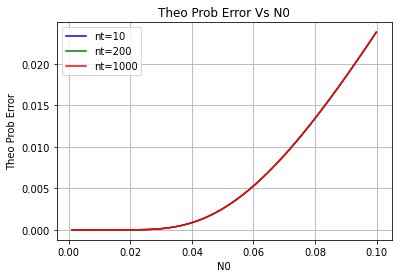

In [ ]:
s0=[0,0,0]
s1=[9,10,9]
s2=[3,4,3]
hk=[1,1,1]
nb=3
ts=10e-4
n0=np.arange(0.001 ,0.1, 0.0001)
nt=5

# fig, (plt1, plt2) = plt.subplots(2)

plt.plot(n0, get_theoandprob_data_trial1(s0, s1,hk,nb,ts,n0,10)["THEO"], 'b', label = "nt=10")
plt.plot(n0, get_theoandprob_data_trial1(s0, s1,hk,nb,ts,n0,200)["THEO"], 'g', label = "nt=200")
plt.plot(n0, get_theoandprob_data_trial1(s0, s1,hk,nb,ts,n0,1000)["THEO"], 'r', label = "nt=1000")
# plt.plot(n0, get_data(s0, s1,s2,hk,nb,ts,n0,10000), 'g', label = "nt=10000")
plt.title('Theo Prob Error Vs N0')
plt.ylabel('Theo Prob Error')
plt.xlabel('N0')
plt.legend()
plt.grid(True)

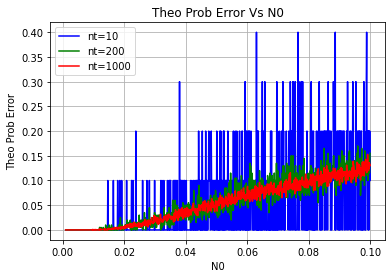

In [ ]:
s0=[0,0,0]
s1=[9,10,9]
s2=[3,4,3]
hk=[1,1,1]
nb=3
ts=10e-4
n0=np.arange(0.001 ,0.1, 0.0001)
nt=5

# fig, (plt1, plt2) = plt.subplots(2)

plt.plot(n0, get_theoandprob_data_trial1(s0, s1,hk,nb,ts,n0,10)["SIMUL"], 'b', label = "nt=10")
plt.plot(n0, get_theoandprob_data_trial1(s0, s1,hk,nb,ts,n0,200)["SIMUL"], 'g', label = "nt=200")
plt.plot(n0, get_theoandprob_data_trial1(s0, s1,hk,nb,ts,n0,1000)["SIMUL"], 'r', label = "nt=1000")
# plt.plot(n0, get_data(s0, s1,s2,hk,nb,ts,n0,10000), 'g', label = "nt=10000")
plt.title('Theo Prob Error Vs N0')
plt.ylabel('Theo Prob Error')
plt.xlabel('N0')
plt.legend()
plt.grid(True)

## ***For more than just 0 or 1 bit***

### (Not the best approach, its more hardcoded) knowing what noise-free filter output is large 

In [ ]:
def trial_2(s0, s1,s2,hk,nb,ts,n0,nt):
  error_count =0
  zero_count =0
  one_count = 0
  # size_nb = len(nb)
  # tb = size_nb*ts
  binary_vector = []
  modulated_vector = []
  noisy_signal = []
  out_array = []
  results_array = []

  output = {}

  #for optimal h[k] is the reverse of h[k]
  hk = np.flip(hk)

  #noise-free filter outputs for the 2 sequences
  #note ns0 = 0 because s0[k] is a [0,0,0,..] vector (depicting no signal)
  ns0 =  np.dot(s0,hk)
  ns1 =  np.dot(s1,hk)
  ns2 =  np.dot(s2,hk)
  
  for i in range(0, nt):
    # Generate random bit
    x = random.choice([0,1,2])
    binary_vector.append(x)

    # modulation
    if x == 0:
      mod_signal = s0# no signal
    elif x ==1:
      mod_signal = s1#signal
    else:
      mod_signal = s2#signal
    modulated_vector = np.append(modulated_vector,mod_signal)

    # Generate guassian white noise
    a = sigma_sum(0, nb-1, lambda i: (hk[i])**2 )
    v = (n0*a)/(2*ts) # variance
    noise = np.random.normal(0,v, nb)

    # addition of white noise
    if x == 0:
      y = np.add(s0,noise)# no signal
    elif x ==1:
      y = np.add(s1,noise) # signal present
    else:
      y = np.add(s2,noise) # signal present

    noisy_signal = np.append(noisy_signal,y)

    #detecting the bit
    out = np.dot(y,hk)
    out_array.append(out)

    #optimal threshold
    z1 = (ns1+ns0)/2 
  
    if out >= z1:
      result = 1
    else:
      result = 0

    z2 = (ns1+ns0+ns2)/2
    if out >= z2:
      result = 2

    if x ==0:
      result =0

    results_array.append(result)

    if result != x:
      error_count += 1

  
  prob_error = (error_count/nt)
  prob_one = (one_count/nt)
  prob_zero = (zero_count/nt)
  
  # theoratical probability error
  # theor_prob_error = 

  output["noise-free filter for s0[k]"] = ns0
  output["noise-free filter for s1[k]"] = ns1
  output["noise-free filter for s2[k]"] = ns2
  output["Threshold1"] = z1
  output["Threshold2"] = z2
  output["Generated bits"] = binary_vector
  output["Modulated vector"] = modulated_vector
  output["Noisy signal(y)"] =  noisy_signal
  output["Noisy signal(y) dot product filter for detection purposes"] =  out_array
  output["Resulting bits afer detection"] = results_array
  output["Simulated probablity error"] = prob_error

  return output

In [ ]:
s0=[0,0,0]
s1=[1,1,1]
s2=[3,3,3]
hk=[1,1,1]
nb=3
ts=10e-4
n0=10000
nt=5
trial_2(s0, s1,s2,hk,nb,ts,n0,nt)

{'Generated bits': [2, 0, 0, 2, 2],
 'Modulated vector': array([3., 3., 3., 0., 0., 0., 0., 0., 0., 3., 3., 3., 3., 3., 3.]),
 'Noisy signal(y)': array([  8948925.9365461 ,  11342792.51692191,  -1409735.62097411,
          4388181.58600406,   5560547.4750136 ,   -676861.36408174,
        -11739232.5859391 , -11896896.68918556,  -9293272.7634462 ,
         18219422.90497612,    820713.59294501,  12451023.18668553,
          7893997.73693592,  -2851169.67634041,  -6402470.28946432]),
 'Noisy signal(y) dot product filter for detection purposes': [18881982.832493905,
  9271867.696935916,
  -32929402.038570862,
  31491159.684606656,
  -1359642.2288688011],
 'Resulting bits afer detection': [2, 0, 0, 2, 0],
 'Simulated probablity error': 0.2,
 'Threshold1': 1.5,
 'Threshold2': 6.0,
 'noise-free filter for s0[k]': 0,
 'noise-free filter for s1[k]': 3,
 'noise-free filter for s2[k]': 9}

### (Not the best approach, its more hardcoded) **NOT** knowing what noise-free filter output is large 

In [ ]:
# for 2 signal types not knowing which is bigger

def trial_3(s0, s1,s2,hk,nb,ts,n0,nt):
  error_count =0
  zero_count =0
  one_count = 0
  # size_nb = len(nb)
  # tb = size_nb*ts
  binary_vector = []
  modulated_vector = []
  noisy_signal = []
  out_array = []
  results_array = []

  output = {}
  #for optimal h[k] is the reverse of h[k]
  hk = np.flip(hk)

  #noise-free filter outputs for the 2 sequences
  #note ns0 = 0 because s0[k] is a [0,0,0,..] vector (depicting no signal)
  ns0 =  np.dot(s0,hk)
  ns1 =  np.dot(s1,hk)
  ns2 =  np.dot(s2,hk)

  for i in range(0, nt):
    # Generate random bit
    x = random.choice([0,1,2])
    binary_vector.append(x)

    # modulation
    if x == 0:
      mod_signal = s0# no signal
    elif x ==1:
      mod_signal = s1#signal
    else:
      mod_signal = s2#signal
    modulated_vector = np.append(modulated_vector,mod_signal)

    # Generate guassian white noise
    noise = np.random.normal(0,.1, nb)

    # addition of white noise
    if x == 0:
      y = np.add(s0,noise)# no signal
    elif x ==1:
      y = np.add(s1,noise) # signal present
    else:
      y = np.add(s2,noise) # signal present

    noisy_signal = np.append(noisy_signal,y)

    #detecting the bit
    out = np.dot(y,hk)
    out_array.append(out)

    #optimal threshold
    min_ns = min(ns1,ns2)

    z1 = (min_ns)/2 

    if out >= z1:
      if ns1 < ns2:
        result = 1
      else:
        result = 2

    z2 = (ns1+ns2)/2
    
    if out >= z2:
      if ns1 < ns2:
        result = 2
      else:
        result = 1

    if x ==0:
      result =0

    results_array.append(result)

    if result != x:
      error_count += 1

  
  prob_error = (error_count/nt)
  prob_one = (one_count/nt)
  prob_zero = (zero_count/nt)
  
  # theoratical probability error
  # theor_prob_error = 
  output["noise-free filter for s0[k]"] = ns0
  output["noise-free filter for s1[k]"] = ns1
  output["noise-free filter for s2[k]"] = ns2
  output["Threshold1"] = z1
  output["Threshold2"] = z2
  output["Generated bits"] = binary_vector
  output["Modulated vector"] = modulated_vector
  output["Noisy signal(y)"] =  noisy_signal
  output["Noisy signal(y) dot product filter for detection purposes"] =  out_array
  output["Resulting bits afer detection"] = results_array
  output["Simulated probablity error"] = prob_error

  return output

In [ ]:
s0=[0,0,0]
s2=[1,1,1]
s1=[3,3,3]
hk=[1,1,1]
nb=3
ts=10e-4
n0=10000
nt=5
trial_3(s0, s1,s2,hk,nb,ts,n0,nt)

{'Generated bits': [2, 1, 2, 1, 2],
 'Modulated vector': array([1., 1., 1., 3., 3., 3., 1., 1., 1., 3., 3., 3., 1., 1., 1.]),
 'Noisy signal(y)': array([1.03911303, 1.15871814, 1.04300163, 3.07365945, 3.10286241,
        3.00053372, 1.00574777, 0.98883337, 1.14404827, 3.11215797,
        3.07693633, 3.07517536, 0.91374183, 1.04651664, 0.9933769 ]),
 'Noisy signal(y) dot product filter for detection purposes': [3.240832799014511,
  9.177055574884616,
  3.1386294107209567,
  9.264269652690018,
  2.9536353730081597],
 'Resulting bits afer detection': [2, 1, 2, 1, 2],
 'Simulated probablity error': 0.0,
 'Threshold1': 1.5,
 'Threshold2': 6.0,
 'noise-free filter for s0[k]': 0,
 'noise-free filter for s1[k]': 9,
 'noise-free filter for s2[k]': 3}

###  Better approach(hopefully) 
Testing how to know what is generated randomly and detect accordingly

In [ ]:
def trial_4(s0, s1,s2,hk,nb,ts,n0,nt):

  #initialization
  error_count =0
  zero_count =0
  one_count = 0
  other_count = 0
  # size_nb = len(nb)
  # tb = size_nb*ts
  binary_vector = []
  modulated_vector = []
  noisy_signal = []
  out_array = []
  results_array = []

  output ={}

  #for optimal h[k] is the reverse of h[k]
  hk = np.flip(hk)

  ns0 =  np.dot(s0,hk)
  ns1 =  np.dot(s1,hk)
  ns2 =  np.dot(s2,hk)
  arr = [] # array that stores the unique non zero bits generated

  for i in range(0, nt):
    # Generate random bit
    x = random.choice([0,1,2])
    binary_vector.append(x)

    if x not in arr and x != 0:
      arr.append(x)

    #to detect the min/max of the 2 types of signals (or 2 non zero values generated)
    sort_arr = np.sort(arr)

    # modulation and adding noise
    # Generate guassian white noise
    a = sigma_sum(0, nb-1, lambda i: (hk[i])**2 )
    v = (n0*a)/(2*ts) # variance
    v2 = (n0)/(2*ts) # variance
    noise = np.random.normal(0,v2, nb)

    # addition of white noise
    if x == 0: # no signal
      y = s0 # ignored
      mod_signal = s0
    else: # signal detected
      if len(sort_arr) == 2 : #if both the sigals are detected and stored in the array
        if x == sort_arr[0]:  #  then check if the generated value is equal to min value in the array
          y = np.add(s1,noise) 
          mod_signal = s1  # s1[k] sequence for the min signal/min non zero value generated
        else:
          y = np.add(s2,noise) 
          mod_signal = s2  # s2[k] sequence for the min signal/min non zero value generated
      else: #else only one non zero value in the array
        y = np.add(s1,noise) 
        mod_signal = s1 

    modulated_vector = np.append(modulated_vector,mod_signal)
    noisy_signal = np.append(noisy_signal,y)

    #process of detecting the value
    out = np.dot(y,hk)
    out_array.append(out)

    #using optimal threshold equation 
    #using the same concept used in on=off keyong (assuming 0 and 1 generated are equiprobable, which will not be true always according to this code)
    min_ns = min(ns1,ns2)

    #threshold 1
    z1 = (min_ns)/2 

    # note: array is refered to the array that stores the unique non zero bits generated

    # to detect the min non-zero value
    if out >= z1:
      if ns1 < ns2: # if noise-free filter of s1[k] < s2[k]
        if len(sort_arr) != 0: # if array is not empty
          result = sort_arr[0] # result should be the min value in the array bcs min value generated is modulated to s1[k]
        else: # if array is empty (non zero bit is not yet generated)
          result =0
      else:
        if len(sort_arr) ==2: # if array is full/size 2 in this case
          result = sort_arr[1] # result should be the min value in the array bcs min value generated is modulated to s2[k]
    else:
      result = 0

    # to detect the max/other non-zero value (max because there will be only 2 non zero values)
    z2 = (ns1+ns2)/2
    if out >= z2:
      if ns1 < ns2:
        if len(sort_arr) ==2:
          result = sort_arr[1]
        else:
          result = 0
      else:
        if len(sort_arr) != 0:
          result = sort_arr[0]
        else:
          result =0
    else:
      result = 0

    # if generated value is 0 then result will be 0 ( no signal part)
    # if x ==0:
    #   result =0

    results_array.append(result)

    if result != x:
      error_count += 1

    if result == 0:
      zero_count += 1
    elif len(sort_arr) > 0:
      if (result == sort_arr[0]):
        one_count += 1
      else:
        other_count += 1

  prob_error = (error_count/nt)
  prob_one = (one_count/nt)
  prob_other = (other_count/nt)
  prob_zero = (zero_count/nt)
  
  # theoratical probability error
  theor_prob_error = ( 0.5*math.erfc( abs(ns0-z1)/math.sqrt(2*v) )*prob_zero ) + ( 0.5*math.erfc( ( (abs(z1-ns1)+abs(ns1-z2))/2 )/math.sqrt(2*v) )*prob_one ) + ( 0.5*math.erfc( abs(ns2-z2)/math.sqrt(2*v) )*prob_other )


  output["noise-free filter for s0[k]"] = ns0
  output["noise-free filter for s1[k]"] = ns1
  output["noise-free filter for s2[k]"] = ns2
  output["Threshold1"] = z1
  output["Threshold2"] = z2
  output["Generated bits"] = binary_vector
  output["Modulated vector"] = modulated_vector
  output["Noisy signal(y)"] =  noisy_signal
  output["Noisy signal(y) dot product filter for detection purposes"] =  out_array
  output["Resulting bits afer detection"] = results_array
  output["Simulated probablity error"] = prob_error
  output["Theoratical probablity error"] = theor_prob_error

  return output

In [ ]:
def trial_4(s0, s1,s2,hk,nb,ts,n0,nt):

  #initialization
  error_count =0
  zero_count =0
  one_count = 0
  other_count = 0
  # size_nb = len(nb)
  # tb = size_nb*ts
  binary_vector = []
  modulated_vector = []
  noisy_signal = []
  out_array = []
  results_array = []

  output ={}

  #for optimal h[k] is the reverse of h[k]
  hk = np.flip(hk)

  ns0 =  np.dot(s0,hk)
  ns1 =  np.dot(s1,hk)
  ns2 =  np.dot(s2,hk)
  arr = [] # array that stores the unique non zero bits generated

  for i in range(0, nt):
    # Generate random bit
    x = random.choice([0,1,2])
    binary_vector.append(x)

    if x not in arr and x != 0:
      arr.append(x)

    #to detect the min/max of the 2 types of signals (or 2 non zero values generated)
    sort_arr = np.sort(arr)

    # modulation and adding noise
    # Generate guassian white noise
    a = sigma_sum(0, nb-1, lambda i: (hk[i])**2 )
    v = (n0*a)/(2*ts) # variance
    noise = np.random.normal(0,math.sqrt(v), nb)

    # addition of white noise
    if x == 0: # no signal
      y = s0 # ignored
      mod_signal = s0
    else: # signal detected
      if len(sort_arr) == 2 : #if both the sigals are detected and stored in the array
        if x == sort_arr[0]:  #  then check if the generated value is equal to min value in the array
          y = np.add(s1,noise) 
          mod_signal = s1  # s1[k] sequence for the min signal/min non zero value generated
        else:
          y = np.add(s2,noise) 
          mod_signal = s2  # s2[k] sequence for the min signal/min non zero value generated
      else: #else only one non zero value in the array
        y = np.add(s1,noise) 
        mod_signal = s1 

    modulated_vector = np.append(modulated_vector,mod_signal)
    noisy_signal = np.append(noisy_signal,y)

    #process of detecting the value
    out = np.dot(y,hk)
    out_array.append(out)

    #using optimal threshold equation 
    #using the same concept used in on=off keyong (assuming 0 and 1 generated are equiprobable, which will not be true always according to this code)
    min_ns = min(ns1,ns2)

    #threshold 1
    z1 = (min_ns)/2 

    # to detect the max/other non-zero value (max because there will be only 2 non zero values)
    z2 = (ns1+ns2)/2

    if out < z1:
      result = 0
    elif out >= z1 and out < z2 and len(sort_arr) >= 1:
      result = sort_arr[0]
    elif out >= z2 and len(sort_arr) > 1:
      result = sort_arr[1] 
    else:
      result =0
    

    # if generated value is 0 then result will be 0 ( no signal part)
    # if x ==0:
    #   result =0

    results_array.append(result)

    if result != x:
      error_count += 1

    if result == 0:
      zero_count += 1
    elif len(sort_arr) > 0:
      if (result == sort_arr[0]):
        one_count += 1
      else:
        other_count += 1

    

  
  prob_error = (error_count/nt)
  prob_one = (one_count/nt)
  prob_other = (other_count/nt)
  prob_zero = (zero_count/nt)
  
  # theoratical probability error
  theor_prob_error = ( 0.5*math.erfc( abs(ns0-z1)/math.sqrt(2*v) )*prob_zero ) + ( 0.5*math.erfc( ( (abs(z1-ns1)+abs(ns1-z2))/2 )/math.sqrt(2*v) )*prob_one ) + ( 0.5*math.erfc( abs(ns2-z2)/math.sqrt(2*v) )*prob_other )
  
  # other way
  # d = ns2-ns1
  # m = 2
  # theor_prob_error = (m-1/m)*math.erfc(d/ (2*math.sqrt(2*v)) )

  output["noise-free filter for s0[k]"] = ns0
  output["noise-free filter for s1[k]"] = ns1
  output["noise-free filter for s2[k]"] = ns2
  output["Threshold1"] = z1
  output["Threshold2"] = z2
  output["Generated bits"] = binary_vector
  output["Modulated vector"] = modulated_vector
  output["Noisy signal(y)"] =  noisy_signal
  output["Noisy signal(y) dot product filter for detection purposes"] =  out_array
  output["Resulting bits afer detection"] = results_array
  output["Simulated probablity error"] = prob_error
  output["Theoratical probablity error"] = theor_prob_error

  return output

In [ ]:
s0=[0,0,0]
s1=[2,2,2]
s2=[4,4,4]
hk=[1,1,1]
ns0 =  np.dot(s0,hk)
ns1 =  np.dot(s1,hk)
ns2 =  np.dot(s2,hk)
ns0,ns1,ns2

(0, 6, 12)

In [ ]:
s0=[0,0,0]
s1=[2,2,2]
s2=[4,4,4]
hk=[1,1,1]
nb=3
ts=10e-4
n0=10000
nt=5

trial_4(s0, s1,s2,hk,nb,ts,n0,nt)

{'Generated bits': [0, 0, 0, 5, 0],
 'Modulated vector': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  9., 10.,  9.,  0.,
         0.,  0.]),
 'Noisy signal(y)': array([       0.        ,        0.        ,        0.        ,
               0.        ,        0.        ,        0.        ,
               0.        ,        0.        ,        0.        ,
        -5322592.63989204, -7637456.61710699, -7068951.55008474,
               0.        ,        0.        ,        0.        ]),
 'Noisy signal(y) dot product filter for detection purposes': [0,
  0,
  0,
  -20029000.807083774,
  0],
 'Resulting bits afer detection': [0, 0, 0, 0, 0],
 'Simulated probablity error': 0.2,
 'Theoratical probablity error': 0.5006307828676788,
 'Threshold1': 5.0,
 'Threshold2': 19.0,
 'noise-free filter for s0[k]': 0,
 'noise-free filter for s1[k]': 28,
 'noise-free filter for s2[k]': 10}

#### Prob vs N0

In [ ]:
def get_data(s0, s1,s2,hk,nb,ts,n0,nt):
  prob_error = []

  for no_e in n0:
    prob_error.append(trial_4(s0, s1,s2,hk,nb,ts,no_e,nt)["Simulated probablity error"])

  return prob_error

def get_theoandprob_data(s0, s1,s2,hk,nb,ts,n0,nt):
  prob_error = []
  theo_error = []

  output = {}

  for no_e in n0:
    result = trial_4(s0, s1,s2,hk,nb,ts,no_e,nt)

    prob_error.append(result["Simulated probablity error"])
    theo_error.append(result["Theoratical probablity error"])

  output["THEO"] = theo_error
  output["SIMUL"] = prob_error

  return output


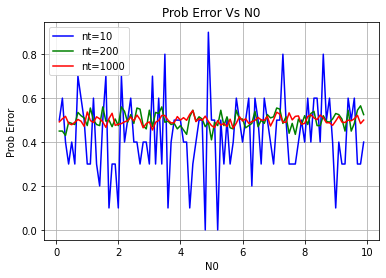

In [ ]:
s0=[0,0,0]
s1=[9,10,9]
s2=[3,4,3]
hk=[1,1,1]
nb=3
ts=10e-4
n0=np.arange(0.1 ,10, 0.1)
nt=5

# fig, (plt1, plt2) = plt.subplots(2)

plt.plot(n0, get_data(s0, s1,s2,hk,nb,ts,n0,10), 'b', label = "nt=10")
plt.plot(n0, get_data(s0, s1,s2,hk,nb,ts,n0,200), 'g', label = "nt=200")
plt.plot(n0, get_data(s0, s1,s2,hk,nb,ts,n0,1000), 'r', label = "nt=1000")
# plt.plot(n0, get_data(s0, s1,s2,hk,nb,ts,n0,10000), 'g', label = "nt=10000")
plt.title('Prob Error Vs N0')
plt.ylabel('Prob Error')
plt.xlabel('N0')
plt.legend()
plt.grid(True)

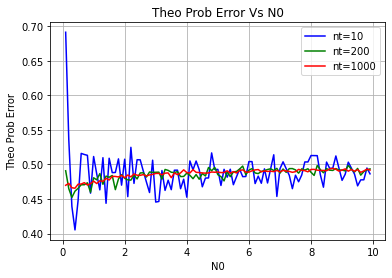

In [ ]:
s0=[0,0,0]
s1=[9,10,9]
s2=[3,4,3]
hk=[1,1,1]
nb=3
ts=10e-4
n0=np.arange(0.1 ,10, 0.1)
nt=5

# fig, (plt1, plt2) = plt.subplots(2)

plt.plot(n0, get_theoandprob_data(s0, s1,s2,hk,nb,ts,n0,10)["THEO"], 'b', label = "nt=10")
plt.plot(n0, get_theoandprob_data(s0, s1,s2,hk,nb,ts,n0,200)["THEO"], 'g', label = "nt=200")
plt.plot(n0, get_theoandprob_data(s0, s1,s2,hk,nb,ts,n0,1000)["THEO"], 'r', label = "nt=1000")
# plt.plot(n0, get_data(s0, s1,s2,hk,nb,ts,n0,10000), 'g', label = "nt=10000")
plt.title('Theo Prob Error Vs N0')
plt.ylabel('Theo Prob Error')
plt.xlabel('N0')
plt.legend()
plt.grid(True)

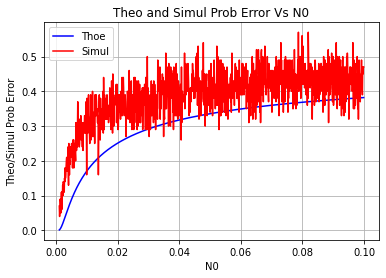

In [ ]:
s0=[0,0,0]
s1=[2,2,2]
s2=[4,4,4]
hk=[1,1,1]
nb=3
ts=10e-4
n0=np.arange(0.001 ,0.1, 0.0001)
nt=5

# fig, (plt1, plt2) = plt.subplots(2)
results = get_theoandprob_data(s0, s1,s2,hk,nb,ts,n0,100)

plt.plot(n0, results["THEO"], 'b', label = "Thoe")
plt.plot(n0, results["SIMUL"], 'r', label = "Simul")
# plt.plot(n0, get_data(s0, s1,s2,hk,nb,ts,n0,10000), 'g', label = "nt=10000")
plt.title('Theo and Simul Prob Error Vs N0')
plt.ylabel('Theo/Simul Prob Error')
plt.xlabel('N0')
plt.legend()
plt.grid(True)

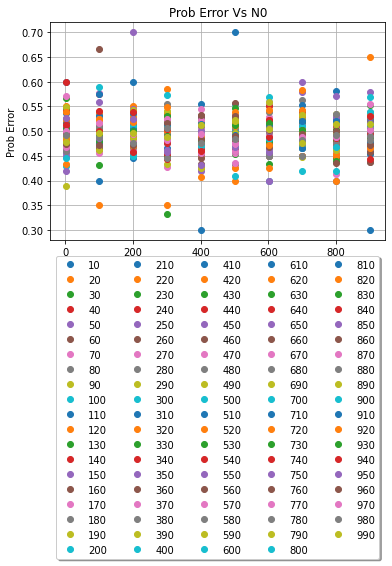

In [ ]:
s0=[0,0,0]
s1=[9,10,9]
s2=[3,4,3]
hk=[1,1,1]
nb=3
ts=10e-4
n0=np.arange(1 ,1000, 100)
nt=np.arange(10 ,1000, 10)

for nt_e in nt:
  plt.plot(n0, get_data(s0, s1,s2,hk,nb,ts,n0,nt_e), 'o', label = nt_e)

plt.title('Prob Error Vs N0')
plt.ylabel('Prob Error')
plt.xlabel('N0')
plt.legend(loc='upper center',bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.grid(True)

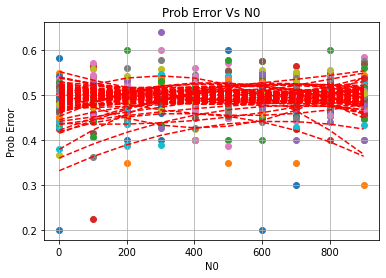

In [ ]:
# s0=[0,0,0]
# s1=[9,10,9]
# s2=[3,4,3]
# hk=[1,1,1]
# nb=3

nb = 100
s0=[random.randint(1,10) for i in range(nb)]
s1=[random.randint(1,10) for i in range(nb)]
s2=[random.randint(1,10) for i in range(nb)]
hk=[random.randint(1,10) for i in range(nb)]

ts=10e-4
n0=np.arange(1 ,1000, 100)
nt=np.arange(10 ,1000, 10)

for nt_e in nt:
  results = get_data(s0, s1,s2,hk,nb,ts,n0,nt_e)
  plt.scatter(n0, results)

  z = np.polyfit(n0, results, 2)
  p = np.poly1d(z)
  plt.plot(n0,p(n0),"r--")

plt.title('Prob Error Vs N0')
plt.ylabel('Prob Error')
plt.xlabel('N0')
# plt.legend(loc='upper center',bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=5)
plt.grid(True)

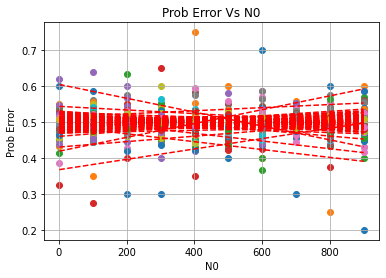

In [ ]:
s0=[0,0,0]
s1=[9,10,9]
s2=[3,4,3]
hk=[1,1,1]
nb=3
ts=10e-4
n0=np.arange(1 ,1000, 100)
nt=np.arange(10 ,1000, 10)

# from colour import Color
# red = Color("red")
# colors = list(red.range_to(Color("green"),10))

for nt_e in nt:
  results = get_data(s0, s1,s2,hk,nb,ts,n0,nt_e)
  plt.scatter(n0, results)

  z = np.polyfit(n0, results, 1)
  p = np.poly1d(z)
  plt.plot(n0,p(n0),"r--")

plt.title('Prob Error Vs N0')
plt.ylabel('Prob Error')
plt.xlabel('N0')
plt.grid(True)

In [ ]:
n0

### Approach using alpha

In [ ]:
def trial_5_1dspace(sx,xy,alpha, bita,hk,nb,ts,n0,nt):

  #initialization
  error_count =0
  zero_count =0
  one_count = 0
  other_count = 0
  # size_nb = len(nb)
  # tb = size_nb*ts
  binary_vector = []
  modulated_vector = []
  noisy_signal = []
  out_array = []
  results_array = []

  output ={}

  #for optimal h[k] is the reverse of h[k]
  hk = np.flip(sx)

  # ns0x =  np.dot(s0x,hk)
  # ns0y =  np.dot(s0y,hk)
  # ns1x =  np.dot(s1x,hk)
  # ns1y =  np.dot(s1y,hk)
  # ns2x =  np.dot(s2x,hk)
  # ns2y =  np.dot(s2y,hk)

  #signals 
  s0 = np.multiply(alpha[0],sx) # vector
  s1 = np.multiply(alpha[1],sx)
  s2 = np.multiply(alpha[2],sx)

  arr = [] # array that stores the unique non zero bits generated

  for i in range(0, nt):
    # Generate random bit
    x = random.choice([0,1])
    binary_vector.append(x)

    if x not in arr and x != 0:
      arr.append(x)

    #to detect the min/max of the 2 types of signals (or 2 non zero values generated)
    sort_arr = np.sort(arr)

    # modulation and adding noise
    # Generate guassian white noise
    a = sigma_sum(0, nb-1, lambda i: (hk[i])**2 )
    v = (n0*a)/(2*ts) # variance
    v2 = (n0)/(2*ts) # variance
    noise = np.random.normal(0,math.sqrt(v2), nb)

    # addition of white noise
    # if x == 0: # no signal
    #   y = s0 # ignored
    #   mod_signal = s0
    # else: # signal detected
    #   if len(sort_arr) == 2 : #if both the sigals are detected and stored in the array
    #     if x == sort_arr[0]:  #  then check if the generated value is equal to min value in the array
    #       y = np.add(s1,noise) 
    #       mod_signal = s1  # s1[k] sequence for the min signal/min non zero value generated
    #     else:
    #       y = np.add(s2,noise) 
    #       mod_signal = s2  # s2[k] sequence for the min signal/min non zero value generated
    #   else: #else only one non zero value in the array
    #     y = np.add(s1,noise) 
    #     mod_signal = s1 

    if x == 0: # no signal
      y = np.add(s0,noise)  # ignored
      mod_signal = s0
    else: #else only one non zero value in the array
        y = np.add(s1,noise) 
        mod_signal = s1    

    modulated_vector = np.append(modulated_vector,mod_signal)
    noisy_signal = np.append(noisy_signal,y)

    #process of detecting the value
    # page 48 y.sx and y.sy -> dot product with basis vectors
    # usually in 1D out = np.dot(y,hk)
    outx = np.dot(y,sx)

    # thresholds
    z = {}

    for i in range(1, len(alpha)-1):
      z[i] = (alpha[i-1] + alpha[i])/2

    if outx < z[1] :
      result  = 0
    elif outx >= z[1]:
      result = 1

    results_array.append(result)
    if result != x:
       error_count +=1
  
  prob_error = (error_count/nt)
  prob_one = (one_count/nt)
  prob_other = (other_count/nt)
  prob_zero = (zero_count/nt)
  
  # theoratical probability error
  # theor_prob_error = ( 0.5*math.erfc( abs(ns0-z1)/math.sqrt(2*v) )*prob_zero ) + ( 0.5*math.erfc( ( (abs(z1-ns1)+abs(ns1-z2))/2 )/math.sqrt(2*v) )*prob_one ) + ( 0.5*math.erfc( abs(ns2-z2)/math.sqrt(2*v) )*prob_other )
  theor_prob_error = ( (1/2)*math.erfc( (z[1]-alpha[0])/math.sqrt(2*v) )*0.5 ) + ( (1/2)*math.erfc( (alpha[1]-z[1])/math.sqrt(2*v) )*0.5 )
  # other way
  # d = 1
  # m = 2
  # theor_prob_error = (m-1/m)*math.erfc(d/ (2*math.sqrt(2*v)) )

  output["Generated bits"] = binary_vector
  output["Modulated vector"] = modulated_vector
  output["Noisy signal(y)"] =  noisy_signal
  # output["Noisy signal(y) dot product filter for detection purposes"] =  out_array
  output["Resulting bits afer detection"] = results_array
  output["Simulated probablity error"] = prob_error
  output["Theoratical probablity error"] = theor_prob_error

  return output

In [ ]:
# non bit
def trial_5_1dspace(sx,xy,alpha, bita,hk,nb,ts,n0,nt):

  #initialization
  error_count =0
  zero_count =0
  one_count = 0
  other_count = 0
  # size_nb = len(nb)
  # tb = size_nb*ts
  binary_vector = []
  modulated_vector = []
  noisy_signal = []
  out_array = []
  results_array = []

  output ={}

  #for optimal h[k] is the reverse of h[k]
  hk = np.flip(sx)

  # ns0x =  np.dot(s0x,hk)
  # ns0y =  np.dot(s0y,hk)
  # ns1x =  np.dot(s1x,hk)
  # ns1y =  np.dot(s1y,hk)
  # ns2x =  np.dot(s2x,hk)
  # ns2y =  np.dot(s2y,hk)

  #signals 
  s0 = np.multiply(alpha[0],sx) # vector
  s1 = np.multiply(alpha[1],sx)
  s2 = np.multiply(alpha[2],sx)

  arr = [] # array that stores the unique non zero bits generated

  for i in range(0, nt):
    # Generate random bit
    x = random.choice([0,1,2])
    binary_vector.append(x)

    if x not in arr and x != 0:
      arr.append(x)

    #to detect the min/max of the 2 types of signals (or 2 non zero values generated)
    sort_arr = np.sort(arr)

    # modulation and adding noise
    # Generate guassian white noise
    a = sigma_sum(0, nb-1, lambda i: (hk[i])**2 )
    v = (n0*a)/(2*ts) # variance
    v2 = (n0)/(2*ts) # variance
    noise = np.random.normal(0,math.sqrt(v2), nb)

    # addition of white noise
    # if x == 0: # no signal
    #   y = s0 # ignored
    #   mod_signal = s0
    # else: # signal detected
    #   if len(sort_arr) == 2 : #if both the sigals are detected and stored in the array
    #     if x == sort_arr[0]:  #  then check if the generated value is equal to min value in the array
    #       y = np.add(s1,noise) 
    #       mod_signal = s1  # s1[k] sequence for the min signal/min non zero value generated
    #     else:
    #       y = np.add(s2,noise) 
    #       mod_signal = s2  # s2[k] sequence for the min signal/min non zero value generated
    #   else: #else only one non zero value in the array
    #     y = np.add(s1,noise) 
    #     mod_signal = s1 

    if x == 0: # no signal
      y = np.add(s0,noise)  # ignored
      mod_signal = s0
    elif x==1: #else only one non zero value in the array
        y = np.add(s1,noise) 
        mod_signal = s1 
    elif x==2: #else only one non zero value in the array
        y = np.add(s2,noise) 
        mod_signal = s2 

    modulated_vector = np.append(modulated_vector,mod_signal)
    noisy_signal = np.append(noisy_signal,y)

    #process of detecting the value
    # page 48 y.sx and y.sy -> dot product with basis vectors
    # usually in 1D out = np.dot(y,hk)
    outx = np.dot(y,sx)

    # thresholds
    z = {}

    for i in range(1, len(alpha)):
      z[i] = (alpha[i-1] + alpha[i])/2

    if outx < z[1] :
      result  = 0
    elif outx >= z[1] and outx < z[2]:
      result = 1
    elif outx >= z[2]:
      result = 2



    results_array.append(result)
    if result != x:
       error_count +=1


  
  prob_error = (error_count/nt)
  prob_one = (one_count/nt)
  prob_other = (other_count/nt)
  prob_zero = (zero_count/nt)
  
  # theoratical probability error
  # theor_prob_error = ( 0.5*math.erfc( abs(ns0-z1)/math.sqrt(2*v) )*prob_zero ) + ( 0.5*math.erfc( ( (abs(z1-ns1)+abs(ns1-z2))/2 )/math.sqrt(2*v) )*prob_one ) + ( 0.5*math.erfc( abs(ns2-z2)/math.sqrt(2*v) )*prob_other )
  # theor_prob_error = ( (1/2)*math.erfc( (z[1]-alpha[0])/math.sqrt(2*v) )*0.5 ) + ( (1/2)*math.erfc( (alpha[1]-z[1])/math.sqrt(2*v) )*0.5 )
  # other way
  d = 1
  m = 2
  theor_prob_error = (m-1/m)*math.erfc(d/ (2*math.sqrt(2*v)) )

  output["Generated bits"] = binary_vector
  output["Modulated vector"] = modulated_vector
  output["Noisy signal(y)"] =  noisy_signal
  # output["Noisy signal(y) dot product filter for detection purposes"] =  out_array
  output["Resulting bits afer detection"] = results_array
  output["Simulated probablity error"] = prob_error
  output["Theoratical probablity error"] = theor_prob_error

  return output

In [ ]:
def get_simul_prob_trial5_1D(sx,sy,alpha, bita,hk,nb,ts,n0,nt):
  prob_error = []
  theo_error = []

  output = {}

  for n0_e in n0:
    result = trial_5_1dspace(sx,sy,alpha, bita,hk,nb,ts,n0_e,nt)

    prob_error.append(result["Simulated probablity error"])
    theo_error.append(result["Theoratical probablity error"])
  
  output["THEO"] = theo_error
  output["SIMUL"] = prob_error

  return output

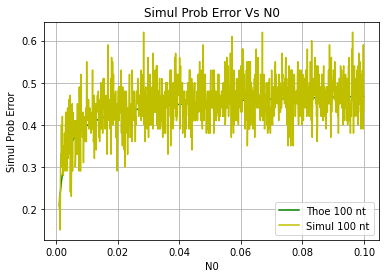

In [ ]:
sx = [1/2,1/2,1/2,1/2]
sy = [1/2,1/2,-1/2,-1/2]
alpha = [1,2,3]
bita = [2,3,4]
hk=[1,1,1]
nb=4
ts=10e-4
n0=np.arange(0.001 ,0.1, 0.0001)
# nt=5
# n0=np.arange(0.001 ,0.2, 0.0001)

# result1 = get_simul_prob_trial5_1D(sx,sy,alpha, bita,hk,nb,ts,n0,1000)
result = get_simul_prob_trial5_1D(sx,sy,alpha, bita,hk,nb,ts,n0,100)

# plt.plot(n0, result1["THEO"], 'b', label = "Thoe 1000 nt")
# plt.plot(n0, result1["SIMUL"], 'r', label = "Simul 1000 nt")
plt.plot(n0, result["THEO"], 'g', label = "Thoe 100 nt")
plt.plot(n0, result["SIMUL"], 'y', label = "Simul 100 nt")
# plt.plot(n0, get_data(s0, s1,s2,hk,nb,ts,n0,10000), 'g', label = "nt=10000")
plt.title('Simul Prob Error Vs N0')
plt.ylabel('Simul Prob Error')
plt.xlabel('N0')
plt.legend()
plt.grid(True)

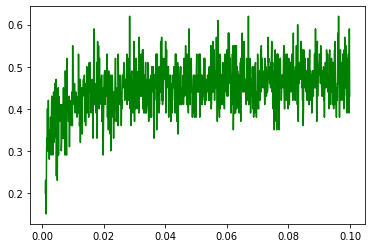

In [ ]:
g2 = plt.plot(n0, result["SIMUL"], 'g', label = "Simul 100 nt")

## **Prob Error/Log Prob Error vs SNR**

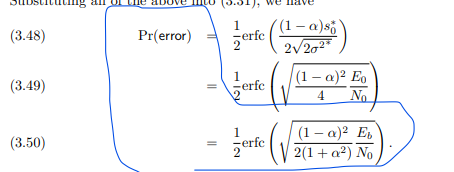

In [ ]:
def sigma_sum(start, end, expression):
    return sum(expression(i) for i in range(start, end))

# the filter is not used according to the equation in the book around pg 37(not sure why )
# For on-off keying, express the probability of error in terms of Eb and N0
# Eb -> Energy per bit, N0 = a constant proportional to temperature of device (according to the book like a noise)
# Eb/N0 called the signal to noise ratio

def plot_info(s0, s1,nb,ts,n0,alpha):

  output = {}

  prob_error = []
  log_prob_error = []
  SNR = []

  for no_e in n0:

    e0 = ts* sigma_sum(0, nb-1, lambda i: (s0[i])**2 )
    e1 = ts* sigma_sum(0, nb-1, lambda i: (s1[i])**2 )
    #eb = e0*prob_zero + e1*prob_one
    eb = (1+alpha**2)*e0/2

    SNR = np.append(SNR, eb/no_e)

    #ts*nb = tb

    exp = ( ((1-alpha)**2 )*eb )/ (2* (1+alpha**2)* no_e )

    pr_error = 0.5*math.erfc( math.sqrt(exp) )

    log_pr_error = math.log(pr_error)

    prob_error = np.append(prob_error, pr_error)
    log_prob_error = np.append(log_prob_error, log_pr_error)

    output["Prob_error"] = prob_error
    output["Log_Prob_error"] = log_prob_error
    output["SNR"] = SNR

  return  output


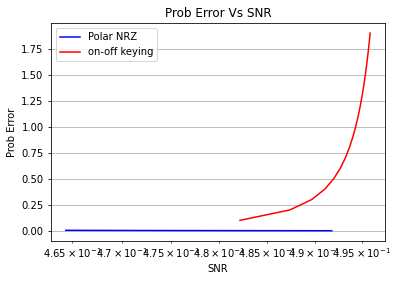

In [ ]:
s0=[2,0,1] 
s1=[1,5,1] 
#hk=[0,1,6]
nb=3
ts=10e-5
n0=np.arange(0.1 ,2, 0.1)
#[1, 10e0, 10e1]
result1 = plot_info(s0, s1,nb,ts,n0, -1) # aplha =-1 for Polar NZR
result2 = plot_info(s0, s1,nb,ts,n0, 0) # aplha =0 for on off keying

plt.plot(result1["Prob_error"], result1["SNR"], 'b', label = "Polar NRZ")
plt.plot(result2["Prob_error"], n0, 'r', label = "on-off keying")
plt.xscale('log')
plt.title('Prob Error Vs SNR')
plt.ylabel('Prob Error')
plt.xlabel('SNR')
plt.legend()
plt.grid(True)


In [ ]:
plt.plot(result1["Log_Prob_error"], result1["SNR"], 'b', label = "Polar NRZ")
plt.plot(result2["Log_Prob_error"], result2["SNR"], 'r', label = "on-off keying")
plt.yscale('log')
plt.title('Log Prob Error Vs SNR')
plt.ylabel('Log Prob Error')
plt.xlabel('SNR')
plt.legend()
plt.grid(True)

## Trying to make it general (not depending the alpha provided)

In [ ]:
def sigma_sum(start, end, expression):
    return sum(expression(i) for i in range(start, end))

# the filter is not used according to the equation in the book around pg 37(not sure why )
#For on-off keying, express the probability of error in terms of Eb and N0
# Eb -> Energy per bit, N0 = a constant proportional to temperature of device (according to the book like a noise)
# Eb/N0 called the signal to noise ratio
def plot_info2(s0, s1,nb,ts,n0):

  output = {}

  prob_error = []
  log_prob_error = []
  SNR = []

  for no_e in n0:

    s_0 = sigma_sum(0, nb-1, lambda i: (s0[i])**2 )
    s_1 = sigma_sum(0, nb-1, lambda i: (s1[i])**2 )
    e0 = ts* s_0
    e1 = ts* s_1
    eb = (e0 + e1)/2
    #eb = (1+alpha**2)*e0/2

    SNR = np.append(SNR, eb/no_e)

    alpha = s_1/s_0
    #ts*nb = tb

    exp = ( ((1-alpha)**2 )*eb )/ (2* (1+alpha**2)* no_e )

    pr_error = 0.5*math.erfc( math.sqrt(exp) )

    log_pr_error = math.log(pr_error)
    
    prob_error = np.append(prob_error, pr_error)
    log_prob_error = np.append(log_prob_error, log_pr_error)

    output["Prob_error"] = prob_error
    output["Log_Prob_error"] = log_prob_error
    output["SNR"] = SNR

  return   output


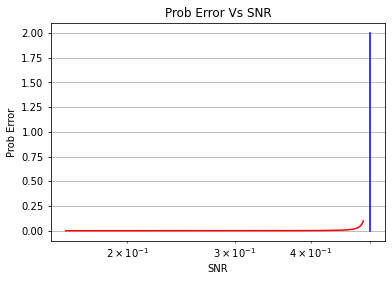

In [ ]:
s0=[1,1,1] 
s1=[1,5,1] 
#hk=[0,1,6]
nb=3
ts=10e-5
n0=np.arange(0.0001 ,0.1, 0.001)
#[1, 10e0,10e1]
result1 = plot_info2([1,1,1], [-1,-1,-1],nb,ts,n0) # aplha =-1 for Polar NZR
result2 = plot_info2([1,1,1], [0,0,0],nb,ts,n0) # aplha =0 for on off keying

plt.plot(result1["Prob_error"], result1["SNR"], 'b', label = "Polar NRZ")
plt.plot(result2["Prob_error"], n0, 'r', label = "on-off keying")
plt.xscale('log')
plt.title('Prob Error Vs SNR')
plt.ylabel('Prob Error')
plt.xlabel('SNR')
plt.grid(True)

## Archive

In [ ]:
# how to know what is generated

def prob_error(s0, s1,s2,hk,nb,ts,n0,z,nt):
  error_count =0
  zero_count =0
  one_count = 0
  # size_nb = len(nb)
  # tb = size_nb*ts
  binary_vector = []
  modulated_vector = []
  noisy_signal = []
  out_array = []
  results_array = []

  #for optimal h[k] is the reverse of h[k]
  hk = np.flip(hk)

  ns0 =  np.dot(s0,hk)
  ns1 =  np.dot(s1,hk)
  ns2 =  np.dot(s2,hk)

  for i in range(0, nt):
    # Generate random bit
    x = random.choice([0,1,2])
    binary_vector.append(x)

    # modulation
    if x == 0:
      mod_signal = s0# no signal
    elif x ==1:
      mod_signal = s1#signal
    else:
      mod_signal = s2#signal
    modulated_vector = np.append(modulated_vector,mod_signal)

    # Generate guassian white noise
    noise = np.random.normal(0,.1, nb)

    # addition of white noise
    if x == 0:
      y = np.add(s0,noise)# no signal
    elif x ==1:
      y = np.add(s1,noise) # signal present
    else:
      y = np.add(s2,noise) # signal present

    noisy_signal = np.append(noisy_signal,y)

    #detecting the bit
    out = np.dot(y,hk)
    out_array.append(out)

    #optimal threshold
    min_ns = min(ns1,ns2)

    z = (min_ns)/2 

    if out >= z:
      if ns1 < ns2:
        result = 1
      else:
        result = 2

    if out >= ((ns1+ns2)/2):
      if ns1 < ns2:
        result = 2
      else:
        result = 1

    if x ==0:
      result =0

    results_array.append(result)

    if result != x:
      error_count += 1

  
  prob_error = (error_count/nt)
  prob_one = (one_count/nt)
  prob_zero = (zero_count/nt)
  
  # theoratical probability error
  # theor_prob_error = 

  return ns1,ns0,ns2,z,error_count, prob_error , binary_vector, modulated_vector, noisy_signal, out_array, results_array

In [ ]:
# arr = []

# for i in range(0, 6):
#     # Generate random bit
#     x = random.choice([0,3,6])

#     if x not in arr and x != 0:
#       arr.append(x)

#     sort_arr = np.sort(arr)

#     if len(sort_arr) == 2 :
#       if x == sort_arr[0]:  # min value
#         y = np.add(s1,noise) 
#       else:
#         y = np.add(s2,noise) 
#     else:
#       # y = np.add(s1,noise) 
    
# print(sort_arr[0])
# print(arr)
# print(np.sort(arr))





In [ ]:
dict = {}

dict["array"] = [2,3,4]

# **2D signal space**

In [ ]:
def trial_5_2dspace(sx,xy,alpha, bita,hk,nb,ts,n0,nt):

  #initialization
  error_count =0
  zero_count =0
  one_count = 0
  other_count = 0
  # size_nb = len(nb)
  # tb = size_nb*ts
  binary_vector = []
  modulated_vector = []
  noisy_signal = []
  out_array = []
  results_array = []

  output ={}

  #for optimal h[k] is the reverse of h[k]
  hk = np.flip(hk)

  # ns0x =  np.dot(s0x,hk)
  # ns0y =  np.dot(s0y,hk)
  # ns1x =  np.dot(s1x,hk)
  # ns1y =  np.dot(s1y,hk)
  # ns2x =  np.dot(s2x,hk)
  # ns2y =  np.dot(s2y,hk)

  #signals 
  s0 = np.add(np.multiply(alpha[0],sx),np.multiply(alpha[0],sy)) # vector
  s1 = np.add(np.multiply(alpha[1],sx),np.multiply(alpha[1],sy))
  s2 = np.add(np.multiply(alpha[2],sx),np.multiply(alpha[2],sy))

  arr = [] # array that stores the unique non zero bits generated

  for i in range(0, nt):
    # Generate random bit
    x = random.choice([0,1])
    binary_vector.append(x)

    if x not in arr and x != 0:
      arr.append(x)

    #to detect the min/max of the 2 types of signals (or 2 non zero values generated)
    sort_arr = np.sort(arr)

    # modulation and adding noise
    # Generate guassian white noise
    a = sigma_sum(0, nb-1, lambda i: (hk[i])**2 )
    v = (n0*a)/(2*ts) # variance
    v2 = (n0)/(2*ts) # variance
    noise = np.random.normal(0,math.sqrt(v2), nb)

    # addition of white noise
    # if x == 0: # no signal
    #   y = s0 # ignored
    #   mod_signal = s0
    # else: # signal detected
    #   if len(sort_arr) == 2 : #if both the sigals are detected and stored in the array
    #     if x == sort_arr[0]:  #  then check if the generated value is equal to min value in the array
    #       y = np.add(s1,noise) 
    #       mod_signal = s1  # s1[k] sequence for the min signal/min non zero value generated
    #     else:
    #       y = np.add(s2,noise) 
    #       mod_signal = s2  # s2[k] sequence for the min signal/min non zero value generated
    #   else: #else only one non zero value in the array
    #     y = np.add(s1,noise) 
    #     mod_signal = s1 

    if x == 0: # no signal
      y = np.add(s0,noise)  # ignored
      mod_signal = s0
    else: #else only one non zero value in the array
        y = np.add(s1,noise) 
        mod_signal = s1    

    modulated_vector = np.append(modulated_vector,mod_signal)
    noisy_signal = np.append(noisy_signal,y)

    #process of detecting the value
    # page 48 y.sx and y.sy -> dot product with basis vectors
    # usually in 1D out = np.dot(y,hk)
    outx = np.dot(y,sx)
    outy = np.dot(y,sy)
    # out_array.append(out)

    d_norm = {}

    for i in range(0, len(alpha)-1):
      norm = math.sqrt( abs(outx - alpha[i] )**2 + abs(outy - bita[i])**2)
      d_norm[i] = norm
    
    #get the key having the minimum norm
    min_norm = min(d_norm, key=d_norm.get)

    if min_norm == 0:
      result = s0
    elif min_norm == 1:
      result = s1
    # elif min_norm == 2:
    #   result = s2
    
    results_array.append(result)
    if min_norm != x:
       error_count +=1


  
  prob_error = (error_count/nt)
  prob_one = (one_count/nt)
  prob_other = (other_count/nt)
  prob_zero = (zero_count/nt)
  
  # theoratical probability error
  # theor_prob_error = ( 0.5*math.erfc( abs(ns0-z1)/math.sqrt(2*v) )*prob_zero ) + ( 0.5*math.erfc( ( (abs(z1-ns1)+abs(ns1-z2))/2 )/math.sqrt(2*v) )*prob_one ) + ( 0.5*math.erfc( abs(ns2-z2)/math.sqrt(2*v) )*prob_other )
  
  # other way
  # d = ns2-ns1
  # m = 2
  # theor_prob_error = (m-1/m)*math.erfc(d/ (2*math.sqrt(2*v)) )

  output["Generated bits"] = binary_vector
  output["Modulated vector"] = modulated_vector
  output["Noisy signal(y)"] =  noisy_signal
  # output["Noisy signal(y) dot product filter for detection purposes"] =  out_array
  output["Resulting bits afer detection"] = results_array
  output["Simulated probablity error"] = prob_error
  # output["Theoratical probablity error"] = theor_prob_error

  return output

In [ ]:
# non bit
def trial_5_2dspace(sx,xy,alpha, bita,hk,nb,ts,n0,nt):

  #initialization
  error_count =0
  zero_count =0
  one_count = 0
  other_count = 0
  # size_nb = len(nb)
  # tb = size_nb*ts
  binary_vector = []
  modulated_vector = []
  noisy_signal = []
  out_array = []
  results_array = []

  output ={}

  #for optimal h[k] is the reverse of h[k]
  hk = np.flip(hk)

  # ns0x =  np.dot(s0x,hk)
  # ns0y =  np.dot(s0y,hk)
  # ns1x =  np.dot(s1x,hk)
  # ns1y =  np.dot(s1y,hk)
  # ns2x =  np.dot(s2x,hk)
  # ns2y =  np.dot(s2y,hk)

  #signals 
  s0 = np.add(np.multiply(alpha[0],sx),np.multiply(bita[0],sy)) # vector
  s1 = np.add(np.multiply(alpha[1],sx),np.multiply(bita[1],sy))
  s2 = np.add(np.multiply(alpha[2],sx),np.multiply(bita[2],sy))

  arr = [] # array that stores the unique non zero bits generated

  for i in range(0, nt):
    # Generate random bit
    x = random.choice([0,1,2])
    binary_vector.append(x)

    if x not in arr and x != 0:
      arr.append(x)

    #to detect the min/max of the 2 types of signals (or 2 non zero values generated)
    sort_arr = np.sort(arr)

    # modulation and adding noise
    # Generate guassian white noise
    a = sigma_sum(0, nb-1, lambda i: (hk[i])**2 )
    v = (n0*a)/(2*ts) # variance
    v2 = (n0)/(2*ts) # variance
    noise = np.random.normal(0,math.sqrt(v2), nb)

    # addition of white noise
    if x == 0: # no signal
      y = s0 # ignored
      mod_signal = s0
    else: # signal detected
      if len(sort_arr) == 2 : #if both the sigals are detected and stored in the array
        if x == sort_arr[0]:  #  then check if the generated value is equal to min value in the array
          y = np.add(s1,noise) 
          mod_signal = s1  # s1[k] sequence for the min signal/min non zero value generated
        else:
          y = np.add(s2,noise) 
          mod_signal = s2  # s2[k] sequence for the min signal/min non zero value generated
      else: #else only one non zero value in the array
        y = np.add(s1,noise) 
        mod_signal = s1 

    modulated_vector = np.append(modulated_vector,mod_signal)
    noisy_signal = np.append(noisy_signal,y)

    #process of detecting the value
    # page 48 y.sx and y.sy -> dot product with basis vectors
    # usually in 1D out = np.dot(y,hk)
    outx = np.dot(y,sx)
    outy = np.dot(y,sy)
    # out_array.append(out)

    d_norm = {}

    for i in range(0, len(alpha)):
      norm = math.sqrt( abs(outx - alpha[i] )**2 + abs(outy - bita[i])**2)
      d_norm[i] = norm
    
    #get the key having the minimum norm
    min_norm = min(d_norm, key=d_norm.get)

    if min_norm == 0:
      result = s0
    elif min_norm == 1:
      result = s1
    elif min_norm == 2:
      result = s2
    
    results_array.append(result)
    if min_norm != x:
       error_count +=1


  
  prob_error = (error_count/nt)
  prob_one = (one_count/nt)
  prob_other = (other_count/nt)
  prob_zero = (zero_count/nt)
  
  # theoratical probability error
  # theor_prob_error = ( 0.5*math.erfc( abs(ns0-z1)/math.sqrt(2*v) )*prob_zero ) + ( 0.5*math.erfc( ( (abs(z1-ns1)+abs(ns1-z2))/2 )/math.sqrt(2*v) )*prob_one ) + ( 0.5*math.erfc( abs(ns2-z2)/math.sqrt(2*v) )*prob_other )
  
  # other way
  # d = ns2-ns1
  # m = 2
  # theor_prob_error = (m-1/m)*math.erfc(d/ (2*math.sqrt(2*v)) )

  output["Generated bits"] = binary_vector
  output["Modulated vector"] = modulated_vector
  output["Noisy signal(y)"] =  noisy_signal
  # output["Noisy signal(y) dot product filter for detection purposes"] =  out_array
  output["Resulting bits afer detection"] = results_array
  output["Simulated probablity error"] = prob_error
  # output["Theoratical probablity error"] = theor_prob_error

  return output

In [ ]:
a = [1,2,3]
b = [4,5,6]
c =2
d =1

np.add(np.multiply(a,c), np.multiply(b,d))


array([ 6,  9, 12])

In [ ]:
def get_simul_prob_trial5(sx,sy,alpha, bita,hk,nb,ts,n0,nt):
  prob_error = []
  # theo_error = []

  output = {}

  for n0_e in n0:
    result = trial_5_2dspace(sx,sy,alpha, bita,hk,nb,ts,n0_e,nt)

    prob_error.append(result["Simulated probablity error"])
    # theo_error.append(result["Theoratical probablity error"])
  
  # output["THEO"] = theo_error
  output["SIMUL"] = prob_error

  return output

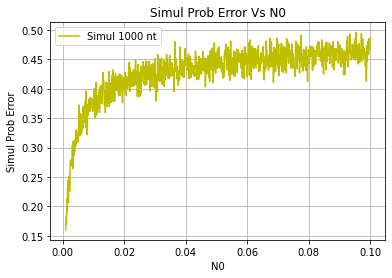

In [ ]:
sx = [1/2,1/2,1/2,1/2]
sy = [1/2,1/2,-1/2,-1/2]
alpha = [1,2,3]
bita = [2,3,4]
hk=[1,1,1]
nb=4
ts=10e-4
n0=np.arange(0.001 ,0.1, 0.0001)
# nt=5
# n0=np.arange(0.001 ,0.2, 0.0001)

# result1 = get_simul_prob_trial5(sx,sy,alpha, bita,hk,nb,ts,n0,50000)
result2 = get_simul_prob_trial5(sx,sy,alpha, bita,hk,nb,ts,n0,1000)

# plt.plot(n0, result1["THEO"], 'b', label = "Thoe 1000 nt")
# plt.plot(n0, result1["SIMUL"], 'r', label = "Simul 100000 nt")
# plt.plot(n0, result2["THEO"], 'g', label = "Thoe 100 nt")
plt.plot(n0, result2["SIMUL"], 'y', label = "Simul 1000 nt")
# plt.plot(n0, get_data(s0, s1,s2,hk,nb,ts,n0,10000), 'g', label = "nt=10000")
plt.title('Simul Prob Error Vs N0')
plt.ylabel('Simul Prob Error')
plt.xlabel('N0')
plt.legend()
plt.grid(True)

In [ ]:

sx = [1,1,1]
sy = [-1,1,-1]
alpha = [1,2,3]
# or
# alpha0= 1
# alpha1= 2
# alpha2= 3

bita = [2,3,4]
# or
# bita1= 2
# bita2= 3
# bita3= 4



s0x=[0,0,0]
s0y=[1,1,1]
s1x=[2,2,2]
s1y=[3,3,3]
s2x=[4,4,4]
s2y=[5,5,5]
hk=[1,1,1]
nb=3
ts=10e-4
# n0=np.arange(0.001 ,0.1, 0.0001)
n0 = 0.001
nt=5

results = trial_5_2dspace(sx,sy,alpha, bita,hk,nb,ts,n0,nt)
results
# results = trial_5_2dspace(sx,xy,alpha, bita,hk,nb,ts,n0,100)
# results = trial_5_2dspace(s0, s1,s2,hk,nb,ts,n0,100)
# # fig, (plt1, plt2) = plt.subplots(2)
# results = get_theoandprob_data(s0, s1,s2,hk,nb,ts,n0,100)

# plt.plot(n0, results["THEO"], 'b', label = "Thoe")
# plt.plot(n0, results["SIMUL"], 'r', label = "Simul")
# # plt.plot(n0, get_data(s0, s1,s2,hk,nb,ts,n0,10000), 'g', label = "nt=10000")
# plt.title('Theo and Simul Prob Error Vs N0')
# plt.ylabel('Theo/Simul Prob Error')
# plt.xlabel('N0')
# plt.legend()
# plt.grid(True)

# TASK : plot for series of n0 s

{'Generated bits': [1, 2, 2, 1, 1],
 'Modulated vector': array([0., 4., 0., 0., 6., 0., 0., 6., 0., 0., 4., 0., 0., 4., 0.]),
 'Noisy signal(y)': array([ 1.00504029,  3.70004998,  0.06364464,  0.27165485,  7.70020745,
         0.74227619, -0.31645885,  5.50207013,  0.28084004,  0.78701998,
         4.51512106, -0.6391998 , -1.5423085 ,  4.96960323, -0.44293467]),
 'Resulting bits afer detection': [2, 2, 2, 2, 2],
 'Simulated probablity error': 0.6}

In [ ]:
a = np.array([[1,2],[3,4],[4,5], [0,6]])
x = [0,1,3,5,1]
y= [6,2,4,6,2]
b = np.array([x, y])
a.argmin()
bout = b.argmin(axis=1)

choose = None

if abs(x[bout[0]] - x[bout[1]]) < abs(y[bout[0]] - y[bout[1]]):
  choose =  bout[1]
else:
  choose =  bout[0]

bout, choose, np.asarray([1,0,3,5,0]).argmin()

# c = []
# c.append(1)
# c.append(2)
# # cc = np.asarray(c)
# cc

# type(cc), type(bout), type(b), type(c)

d = {}

d[0] = 2
d[1] = 1
d[2] = 10

d, min(d), min(d, key=d.get)


({0: 2, 1: 1, 2: 10}, 0, 1)